# RNA Editing Detection - Gills (Peripheral Tissue)

This notebook detects A-to-I RNA editing events in squid Gills tissue (peripheral/non-neural).

**Expected Result:** The Gills are a peripheral tissue that should NOT have widespread A-to-I editing events, unlike the Giant Fiber Lobe (neural tissue).

**Modes:**
- `RUN_MODE = 'sample'`: Process only Spectrin gene (for testing)
- `RUN_MODE = 'full'`: Process all genes in the transcriptome

## Exercise Requirements:
1. Read transcriptome file with ORF annotations
2. Process each gene within ORF regions using pysam pileup
3. Filter reads: unique mapping (quality=42) + base quality ≥30
4. Count bases, identify modifications
5. Calculate p-value using binomial test with Bonferroni correction
6. Output amino acid changes
7. Generate plots: modification types, match/mismatch by read position

In [10]:
### Import libraries and set configuration
import pysam
from scipy.stats import binom
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re

# ==================== RUN MODE CONFIGURATION ====================
# Set to 'sample' for single gene (Spectrin) or 'full' for all genes
RUN_MODE = 'sample'  # Options: 'sample' or 'full'
# ================================================================

### Input parameters
minimum_quality_score = 30  # Quality score 30 = 1/1000 error rate
P = 1e-3  # Probability of sequencing error given quality score of 30
max_mapping_score = 42  # Maximal mapping quality = unique alignment (bowtie2)
p_cutoff = 0.05  # Significance cutoff (before Bonferroni correction)

# File paths - GILLS DATA
bam_file_to_read = "aligned_RNAreads_gills_sorted.bam"
transcriptome_file = "pealeii.txt"
output_file = "editing_sites_Gills.txt" if RUN_MODE == 'full' else "editing_sites_Gills_sample.txt"
progress_file = "progress_Gills.txt" if RUN_MODE == 'full' else "progress_Gills_sample.txt"

# Read length for GILLS data (150bp, different from GFL which is 100bp)
length_of_read = 150

# Spectrin gene for sample run
SPECTRIN_GENE = 'comp141540_c0_seq3'

print(f"Running in {RUN_MODE.upper()} mode")
print(f"BAM file: {bam_file_to_read}")
print(f"Read length: {length_of_read} bp")
print(f"Output file: {output_file}")

Running in SAMPLE mode
BAM file: aligned_RNAreads_gills_sorted.bam
Read length: 150 bp
Output file: editing_sites_Gills_sample.txt


In [11]:
### Define codon table for amino acid translation
CODON_TABLE = {
    'UUU': 'F', 'UUC': 'F', 'UUA': 'L', 'UUG': 'L',
    'UCU': 'S', 'UCC': 'S', 'UCA': 'S', 'UCG': 'S',
    'UAU': 'Y', 'UAC': 'Y', 'UAA': '*', 'UAG': '*',
    'UGU': 'C', 'UGC': 'C', 'UGA': '*', 'UGG': 'W',
    'CUU': 'L', 'CUC': 'L', 'CUA': 'L', 'CUG': 'L',
    'CCU': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAU': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGU': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'AUU': 'I', 'AUC': 'I', 'AUA': 'I', 'AUG': 'M',
    'ACU': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAU': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGU': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GUU': 'V', 'GUC': 'V', 'GUA': 'V', 'GUG': 'V',
    'GCU': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAU': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGU': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

def translate_codon(codon):
    """Translate a 3-base codon to amino acid (convert T to U for lookup)"""
    rna_codon = codon.upper().replace('T', 'U')
    return CODON_TABLE.get(rna_codon, 'X')  # X for unknown

def get_amino_acid_change(sequence, orf_start, orf_end, position, original_base, modified_base):
    """
    Determine the amino acid change caused by a modification.
    
    Args:
        sequence: Full gene sequence (0-indexed)
        orf_start: ORF start position (1-indexed from file, converted to 0-indexed)
        orf_end: ORF end position (1-indexed from file)
        position: Position of modification in sequence (0-indexed)
        original_base: The unmodified base
        modified_base: The modified base
    
    Returns:
        Tuple of (original_aa, modified_aa, codon_position)
    """
    # Convert to 0-indexed ORF coordinates
    orf_start_0 = orf_start - 1  # Convert 1-indexed to 0-indexed
    
    # Position within the ORF (0-indexed)
    pos_in_orf = position - orf_start_0
    
    # Determine which codon and position within codon
    codon_number = pos_in_orf // 3
    codon_position = pos_in_orf % 3  # 0, 1, or 2
    
    # Get the codon start position in the sequence
    codon_start = orf_start_0 + (codon_number * 3)
    
    # Make sure we have enough sequence
    if codon_start + 3 > len(sequence):
        return ('X', 'X', codon_position)
    
    # Get original codon
    original_codon = sequence[codon_start:codon_start + 3]
    
    # Create modified codon
    modified_codon = list(original_codon)
    modified_codon[codon_position] = modified_base
    modified_codon = ''.join(modified_codon)
    
    # Translate both codons
    original_aa = translate_codon(original_codon)
    modified_aa = translate_codon(modified_codon)
    
    return (original_aa, modified_aa, codon_position)

print("Codon table and helper functions loaded.")

Codon table and helper functions loaded.


In [12]:
### Parse transcriptome file
def parse_transcriptome(filename):
    """
    Parse the transcriptome FASTA file.
    
    Returns:
        Dictionary with gene names as keys and dict containing:
        - 'sequence': the RNA sequence
        - 'orf_start': ORF start position (1-indexed)
        - 'orf_end': ORF end position (1-indexed)
        - 'strand': strand direction
        - 'annotation': gene annotation
    """
    genes = {}
    current_gene = None
    current_sequence = []
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                # Save previous gene
                if current_gene is not None:
                    genes[current_gene]['sequence'] = ''.join(current_sequence)
                
                # Parse header
                # Format: >comp132287_c0_seq3\tOrfStart\t106\tOrfEnd\t1338\tStrand\t+\tannotation
                parts = line[1:].split('\t')
                gene_name = parts[0]
                
                # Parse ORF info
                orf_start = int(parts[2])
                orf_end = int(parts[4])
                strand = parts[6]
                annotation = parts[7] if len(parts) > 7 else ''
                
                current_gene = gene_name
                current_sequence = []
                genes[gene_name] = {
                    'orf_start': orf_start,
                    'orf_end': orf_end,
                    'strand': strand,
                    'annotation': annotation,
                    'sequence': ''
                }
            else:
                current_sequence.append(line)
        
        # Save last gene
        if current_gene is not None:
            genes[current_gene]['sequence'] = ''.join(current_sequence)
    
    return genes

# Parse the transcriptome
print("Parsing transcriptome file...")
genes = parse_transcriptome(transcriptome_file)
print(f"Loaded {len(genes)} genes from transcriptome")

# Calculate total ORF size for Bonferroni correction
total_orf_size = sum(g['orf_end'] - g['orf_start'] + 1 for g in genes.values())
print(f"Total ORF size: {total_orf_size:,} bases")

# Show example gene (Spectrin)
if SPECTRIN_GENE in genes:
    spectrin = genes[SPECTRIN_GENE]
    print(f"\nSpectrin gene ({SPECTRIN_GENE}):")
    print(f"  ORF: {spectrin['orf_start']}-{spectrin['orf_end']}")
    print(f"  Sequence length: {len(spectrin['sequence'])}")

Parsing transcriptome file...
Loaded 11963 genes from transcriptome
Total ORF size: 16,619,469 bases

Spectrin gene (comp141540_c0_seq3):
  ORF: 721-7956
  Sequence length: 9044


In [13]:
### Initialize data structures for tracking modifications

# Dictionary for type of modification counts
type_of_modifications = ['AC', 'AG', 'AT', 'CA', 'CG', 'CT', 'GA', 'GC', 'GT', 'TA', 'TC', 'TG']
number_of_modifications = {x: 0 for x in type_of_modifications}

# Arrays for position of mismatch/match in the read (150bp for Gills)
position_of_mismatch_inside_the_read = np.zeros(length_of_read)
position_of_match_inside_the_read = np.zeros(length_of_read)

# Dictionary to track amino acid changes
amino_acid_changes = defaultdict(int)

# List to store all detected editing sites
editing_sites = []

print("Data structures initialized.")

Data structures initialized.


In [14]:
### Main analysis: Detect RNA editing sites

# Open BAM file and output files
samfile = pysam.AlignmentFile(bam_file_to_read, "rb")
output_fh = open(output_file, "w")
progress_fh = open(progress_file, "w")

# Determine which genes to process
if RUN_MODE == 'sample':
    genes_to_process = [SPECTRIN_GENE] if SPECTRIN_GENE in genes else list(genes.keys())[:1]
    print(f"Sample mode: Processing gene {genes_to_process[0]}")
else:
    genes_to_process = list(genes.keys())
    print(f"Full mode: Processing {len(genes_to_process)} genes")

# Write header to output file
output_fh.write("# RNA Editing Analysis - Gills (Peripheral Tissue)\n")
output_fh.write(f"# Mode: {RUN_MODE}\n")
output_fh.write(f"# Total ORF size for Bonferroni: {total_orf_size}\n")
output_fh.write(f"# P-value cutoff (after Bonferroni): {p_cutoff/total_orf_size:.2e}\n\n")

# Process each gene
for gene_idx, transcript_name in enumerate(genes_to_process):
    gene_info = genes[transcript_name]
    orf_start = gene_info['orf_start']
    orf_end = gene_info['orf_end']
    sequence = gene_info['sequence']
    
    # Print progress
    progress_msg = f"Processing gene {gene_idx + 1}/{len(genes_to_process)}: {transcript_name}"
    progress_fh.write(progress_msg + "\n")
    progress_fh.flush()
    
    if (gene_idx + 1) % 100 == 0 or RUN_MODE == 'sample':
        print(progress_msg)
    
    # Write gene info to output
    output_fh.write(f"\n{'='*60}\n")
    output_fh.write(f"Gene: {transcript_name}\n")
    output_fh.write(f"ORF: {orf_start}-{orf_end}\n")
    output_fh.write(f"{'='*60}\n")
    
    # Counts per letter for this position
    counts_per_letter = {}
    
    try:
        # Run over all positions of the transcript
        for pileupcolumn in samfile.pileup(transcript_name, min_mapping_quality=max_mapping_score):
            position = pileupcolumn.pos  # 0-indexed position
            
            # Only process positions within the ORF (convert to 1-indexed for comparison)
            pos_1indexed = position + 1
            if pos_1indexed < orf_start or pos_1indexed > orf_end:
                continue
            
            # Initialize counts
            for letter in ['A', 'C', 'G', 'T']:
                counts_per_letter[letter] = 0
            
            # Count bases at this position
            for pileupread in pileupcolumn.pileups:
                if pileupread.is_del or pileupread.is_refskip:
                    continue
                if pileupread.query_position is None:
                    continue
                    
                # Check quality score
                if pileupread.alignment.query_qualities[pileupread.query_position] >= minimum_quality_score:
                    letter = pileupread.alignment.query_sequence[pileupread.query_position]
                    if letter in counts_per_letter:
                        counts_per_letter[letter] += 1
            
            # Sort counts to find most frequent and second most frequent bases
            sorted_counts = sorted(counts_per_letter.items(), key=lambda x: x[1], reverse=True)
            
            # Get first (unmodified) and second (modified) bases
            first_letter = sorted_counts[0][0]
            first_count = sorted_counts[0][1]
            second_letter = sorted_counts[1][0]
            second_count = sorted_counts[1][1]
            
            # Skip if no modifications detected
            if second_count == 0:
                continue
            
            X = second_count  # Modified base count
            N = first_count + second_count  # Total counts
            modification = first_letter + second_letter
            
            # Calculate p-value for sequencing error
            # P(X or more modifications | sequencing error) = 1 - CDF(X-1)
            # More accurate: binom.cdf(N-X, N, 1-P)
            prob = binom.cdf(N - X, N, 1 - P)
            
            # Apply Bonferroni correction
            if prob < (p_cutoff / total_orf_size):
                # Get amino acid change
                original_aa, modified_aa, codon_pos = get_amino_acid_change(
                    sequence, orf_start, orf_end, position, first_letter, second_letter
                )
                
                # Determine if synonymous or non-synonymous
                if original_aa == modified_aa:
                    aa_change = 'synonymous'
                else:
                    aa_change = f"{original_aa}{modified_aa}"
                
                # Write to output file
                output_fh.write(f"\nPosition: {position} (1-indexed: {pos_1indexed})\n")
                output_fh.write(f"Coverage: {pileupcolumn.n}\n")
                for letter, count in sorted_counts:
                    output_fh.write(f"  {letter}: {count}\n")
                output_fh.write(f"Modification: {modification}\n")
                output_fh.write(f"X (modified): {X}, N (total): {N}\n")
                output_fh.write(f"P-value: {prob:.2e}\n")
                output_fh.write(f"Amino acid change: {aa_change}\n")
                
                # Update modification counts
                number_of_modifications[modification] += 1
                
                # Update amino acid change counts
                amino_acid_changes[aa_change] += 1
                
                # Store editing site info
                editing_sites.append({
                    'gene': transcript_name,
                    'position': position,
                    'modification': modification,
                    'X': X,
                    'N': N,
                    'p_value': prob,
                    'aa_change': aa_change
                })
                
                # Track position of match/mismatch in reads
                for pileupread in pileupcolumn.pileups:
                    if pileupread.is_del or pileupread.is_refskip:
                        continue
                    if pileupread.query_position is None:
                        continue
                    if pileupread.alignment.query_qualities[pileupread.query_position] >= minimum_quality_score:
                        letter = pileupread.alignment.query_sequence[pileupread.query_position]
                        read_pos = pileupread.query_position
                        if read_pos < length_of_read:
                            if letter == first_letter:  # Match
                                position_of_match_inside_the_read[read_pos] += 1
                            elif letter == second_letter:  # Mismatch (modification)
                                position_of_mismatch_inside_the_read[read_pos] += 1
    
    except ValueError as e:
        # Gene not found in BAM file
        output_fh.write(f"Note: Gene not found in BAM file or no alignments\n")
        continue

# Close files
output_fh.close()
progress_fh.close()
samfile.close()

print(f"\nAnalysis complete!")
print(f"Total editing sites detected: {len(editing_sites)}")
print(f"Results saved to: {output_file}")

[W::hts_idx_load3] The index file is older than the data file: aligned_RNAreads_gills_sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: aligned_RNAreads_gills_sorted.bam.bai


Sample mode: Processing gene comp141540_c0_seq3
Processing gene 1/1: comp141540_c0_seq3

Analysis complete!
Total editing sites detected: 5
Results saved to: editing_sites_Gills_sample.txt


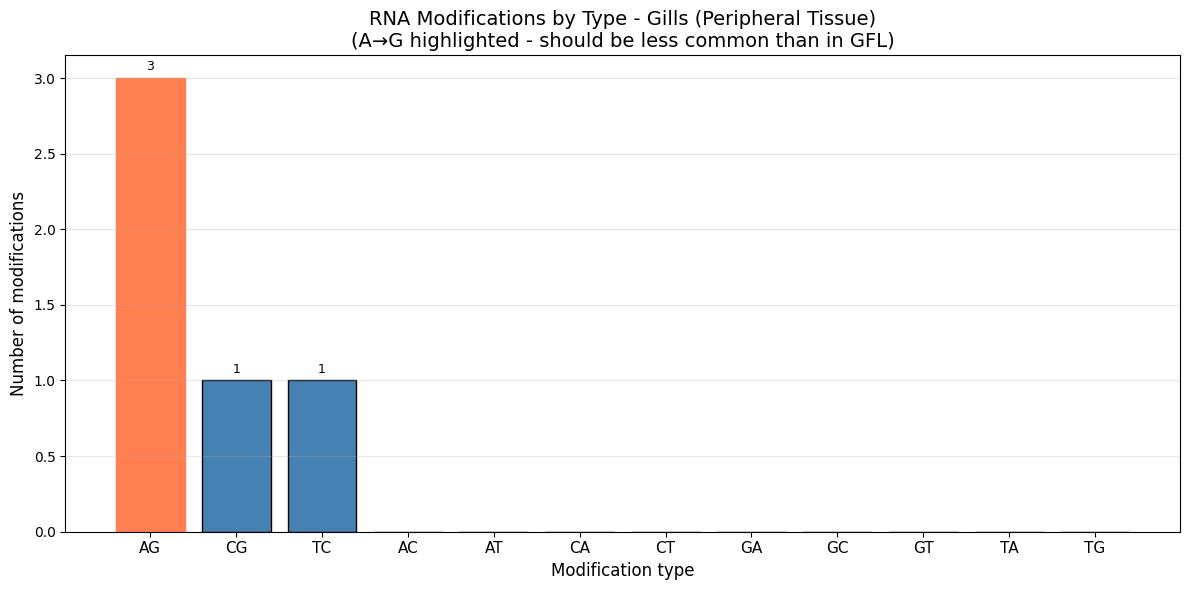


Modification counts:
  AG: 3
  CG: 1
  TC: 1
  AC: 0
  AT: 0
  CA: 0
  CT: 0
  GA: 0
  GC: 0
  GT: 0
  TA: 0
  TG: 0


In [15]:
### Plot 1: Bar plot of modification types

# Sort modifications by count (descending)
sorted_modifications = dict(sorted(number_of_modifications.items(), 
                                   key=lambda item: item[1], 
                                   reverse=True))

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(sorted_modifications)), 
               list(sorted_modifications.values()), 
               align='center',
               color='steelblue',
               edgecolor='black')

# Highlight A-to-G modifications (for comparison with GFL)
for i, (mod_type, count) in enumerate(sorted_modifications.items()):
    if mod_type == 'AG':
        bars[i].set_color('coral')

plt.xticks(range(len(sorted_modifications)), list(sorted_modifications.keys()), fontsize=11)
plt.ylabel('Number of modifications', fontsize=12)
plt.xlabel('Modification type', fontsize=12)
plt.title('RNA Modifications by Type - Gills (Peripheral Tissue)\n(A→G highlighted - should be less common than in GFL)', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
max_val = max(sorted_modifications.values()) if max(sorted_modifications.values()) > 0 else 1
for i, (mod_type, count) in enumerate(sorted_modifications.items()):
    if count > 0:
        plt.text(i, count + max_val*0.01, str(count), 
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('modification_types_Gills.png', dpi=150)
plt.show()

print("\nModification counts:")
for mod_type, count in sorted_modifications.items():
    print(f"  {mod_type}: {count}")

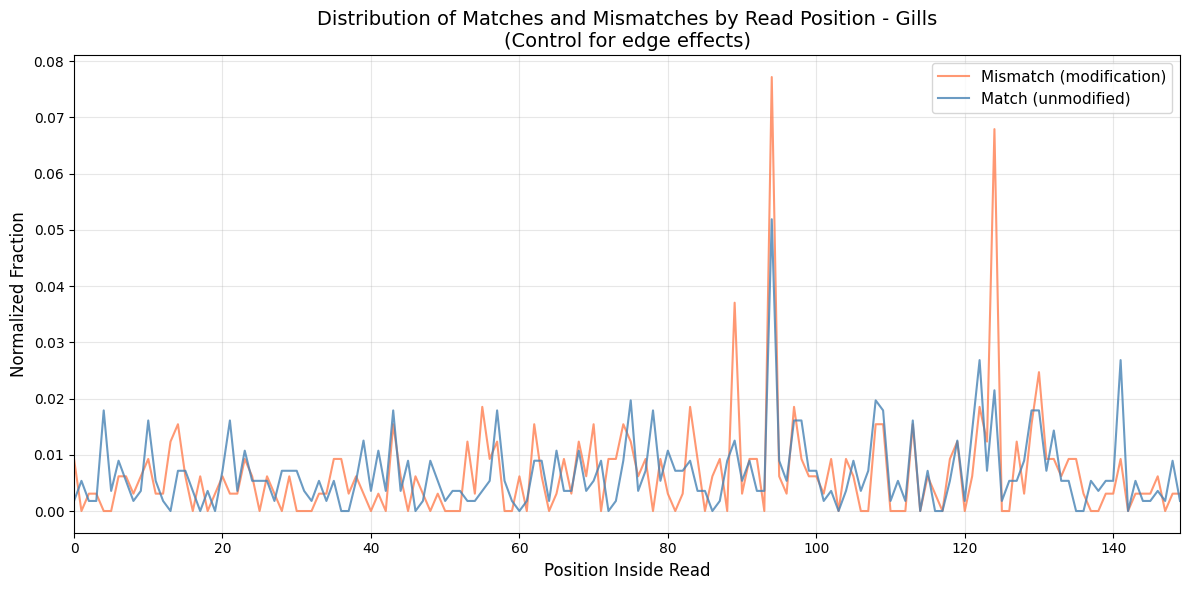

Total mismatches analyzed: 324
Total matches analyzed: 559


In [16]:
### Plot 2: Match/Mismatch positions within reads

plt.figure(figsize=(12, 6))

# Normalize the counts
mismatch_sum = sum(position_of_mismatch_inside_the_read)
match_sum = sum(position_of_match_inside_the_read)

if mismatch_sum > 0:
    normalized_mismatch = position_of_mismatch_inside_the_read / mismatch_sum
else:
    normalized_mismatch = position_of_mismatch_inside_the_read

if match_sum > 0:
    normalized_match = position_of_match_inside_the_read / match_sum
else:
    normalized_match = position_of_match_inside_the_read

# Plot
x_positions = list(range(length_of_read))
plt.plot(x_positions, normalized_mismatch, label='Mismatch (modification)', 
         color='coral', linewidth=1.5, alpha=0.8)
plt.plot(x_positions, normalized_match, label='Match (unmodified)', 
         color='steelblue', linewidth=1.5, alpha=0.8)

plt.ylabel('Normalized Fraction', fontsize=12)
plt.xlabel('Position Inside Read', fontsize=12)
plt.title('Distribution of Matches and Mismatches by Read Position - Gills\n(Control for edge effects)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xlim(0, length_of_read - 1)

plt.tight_layout()
plt.savefig('match_mismatch_positions_Gills.png', dpi=150)
plt.show()

print(f"Total mismatches analyzed: {int(mismatch_sum)}")
print(f"Total matches analyzed: {int(match_sum)}")

In [17]:
### Output 3: Amino acid modifications sorted by frequency

print("=" * 60)
print("AMINO ACID MODIFICATIONS (sorted by frequency)")
print("=" * 60)

# Sort amino acid changes by count (descending)
sorted_aa_changes = sorted(amino_acid_changes.items(), 
                           key=lambda x: x[1], 
                           reverse=True)

# Full amino acid names for reference
aa_names = {
    'A': 'Alanine', 'C': 'Cysteine', 'D': 'Aspartate', 'E': 'Glutamate',
    'F': 'Phenylalanine', 'G': 'Glycine', 'H': 'Histidine', 'I': 'Isoleucine',
    'K': 'Lysine', 'L': 'Leucine', 'M': 'Methionine', 'N': 'Asparagine',
    'P': 'Proline', 'Q': 'Glutamine', 'R': 'Arginine', 'S': 'Serine',
    'T': 'Threonine', 'V': 'Valine', 'W': 'Tryptophan', 'Y': 'Tyrosine',
    '*': 'Stop', 'X': 'Unknown'
}

if sorted_aa_changes:
    print(f"{'Rank':<6}{'Change':<15}{'Count':<10}{'Description'}")
    print("-" * 60)

    for rank, (change, count) in enumerate(sorted_aa_changes, 1):
        if change == 'synonymous':
            description = "Silent mutation (no AA change)"
        else:
            orig_aa = change[0]
            mod_aa = change[1]
            orig_name = aa_names.get(orig_aa, 'Unknown')
            mod_name = aa_names.get(mod_aa, 'Unknown')
            description = f"{orig_name} → {mod_name}"
        
        print(f"{rank:<6}{change:<15}{count:<10}{description}")

    print("-" * 60)
    print(f"Total amino acid modifications: {sum(amino_acid_changes.values())}")
else:
    print("No amino acid modifications detected (as expected for peripheral tissue)")

# Save to file
with open(f"amino_acid_changes_Gills.txt", 'w') as f:
    f.write("Amino Acid Modifications - Gills (Peripheral Tissue)\n")
    f.write("=" * 60 + "\n")
    if sorted_aa_changes:
        f.write(f"{'Rank':<6}{'Change':<15}{'Count':<10}{'Description'}\n")
        f.write("-" * 60 + "\n")
        for rank, (change, count) in enumerate(sorted_aa_changes, 1):
            if change == 'synonymous':
                description = "Silent mutation"
            else:
                description = f"{aa_names.get(change[0], '?')} → {aa_names.get(change[1], '?')}"
            f.write(f"{rank:<6}{change:<15}{count:<10}{description}\n")
    else:
        f.write("No amino acid modifications detected\n")

print(f"\nResults saved to: amino_acid_changes_Gills.txt")

AMINO ACID MODIFICATIONS (sorted by frequency)
Rank  Change         Count     Description
------------------------------------------------------------
1     synonymous     4         Silent mutation (no AA change)
2     IV             1         Isoleucine → Valine
------------------------------------------------------------
Total amino acid modifications: 5

Results saved to: amino_acid_changes_Gills.txt


In [18]:
### Summary Statistics

print("\n" + "=" * 60)
print("SUMMARY - Gills (Peripheral Tissue) RNA Editing Analysis")
print("=" * 60)

print(f"\nRun mode: {RUN_MODE}")
print(f"Genes processed: {len(genes_to_process)}")
print(f"Total ORF size: {total_orf_size:,} bases")
print(f"Bonferroni-corrected p-value threshold: {p_cutoff/total_orf_size:.2e}")

print(f"\nTotal editing sites detected: {len(editing_sites)}")
print(f"Total modifications by type: {sum(number_of_modifications.values())}")

# A-to-G vs others (for A-to-I editing detection)
ag_count = number_of_modifications.get('AG', 0)
total_mods = sum(number_of_modifications.values())
if total_mods > 0:
    ag_percentage = (ag_count / total_mods) * 100
    print(f"\nA-to-G modifications: {ag_count} ({ag_percentage:.1f}% of total)")
else:
    print(f"\nA-to-G modifications: 0")

print("\n" + "-" * 60)
print("INTERPRETATION:")
print("-" * 60)
print("""
The Gills are a peripheral (non-neural) tissue in the squid.
Unlike the Giant Fiber Lobe (a neural tissue), the Gills should
NOT show widespread A-to-I RNA editing events.

If the GFL shows many A→G modifications while the Gills shows
very few, this supports the hypothesis that A-to-I editing is
specific to neural tissues in cephalopods.
""")
print("=" * 60)


SUMMARY - Gills (Peripheral Tissue) RNA Editing Analysis

Run mode: sample
Genes processed: 1
Total ORF size: 16,619,469 bases
Bonferroni-corrected p-value threshold: 3.01e-09

Total editing sites detected: 5
Total modifications by type: 5

A-to-G modifications: 3 (60.0% of total)

------------------------------------------------------------
INTERPRETATION:
------------------------------------------------------------

The Gills are a peripheral (non-neural) tissue in the squid.
Unlike the Giant Fiber Lobe (a neural tissue), the Gills should
NOT show widespread A-to-I RNA editing events.

If the GFL shows many A→G modifications while the Gills shows
very few, this supports the hypothesis that A-to-I editing is
specific to neural tissues in cephalopods.

